<a href="https://colab.research.google.com/github/larissacybyk/machine-learning/blob/main/jdj9ng_Codeathon_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CODEATHON 2: Recognizing UVA landmarks with neural nets (50 pts)
![UVA Grounds](https://giving.virginia.edu/sites/default/files/2019-02/jgi-teaser-image.jpg)

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture.

In this codeathon, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 50 points for this codeathon plus 10 bonus points. To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs.

You must submit the .ipynb file via UVA Collab with the following format: **yourUVAComputingID_codeathon_2.ipynb**

In [1]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Step 1: Process the  Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in my Firebase server. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

In [2]:
# Download dataset from Firebase
!wget https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7

--2024-11-14 18:34:09--  https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media
Resolving firebasestorage.googleapis.com (firebasestorage.googleapis.com)... 172.217.204.95, 172.217.203.95, 142.250.98.95, ...
Connecting to firebasestorage.googleapis.com (firebasestorage.googleapis.com)|172.217.204.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397174132 (379M) [application/zip]
Saving to: ‘dataset.zip?alt=media’

dataset.zip?alt=med 100%[===================>] 378.77M  62.1MB/s    in 5.7s    

2024-11-14 18:34:15 (66.8 MB/s) - ‘dataset.zip?alt=media’ saved [397174132/397174132]



In [3]:
# Extract content
!unzip "/content/dataset.zip?alt=media"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Rotunda/0000010694.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010694.jpg  
  inflating: dataset/Rotunda/0000010680.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010680.jpg  
  inflating: dataset/Rotunda/0000010858.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010858.jpg  
  inflating: dataset/Rotunda/0000010870.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010870.jpg  
  inflating: dataset/Rotunda/0000010864.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010864.jpg  
  inflating: dataset/Rotunda/0000010865.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010865.jpg  
  inflating: dataset/Rotunda/0000010871.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010871.jpg  
  inflating: dataset/Rotunda/0000010859.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010859.jpg  
  inflating: dataset/Rotunda/0000010681.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010681.jpg  
  inflating: dataset/R

In [4]:
from sklearn.datasets import load_files
import keras.utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "/content/dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 224;
img_width = 224;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 14286 files belonging to 18 classes.
Using 11429 files for training.
Found 14286 files belonging to 18 classes.
Using 2857 files for validation.


In [5]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

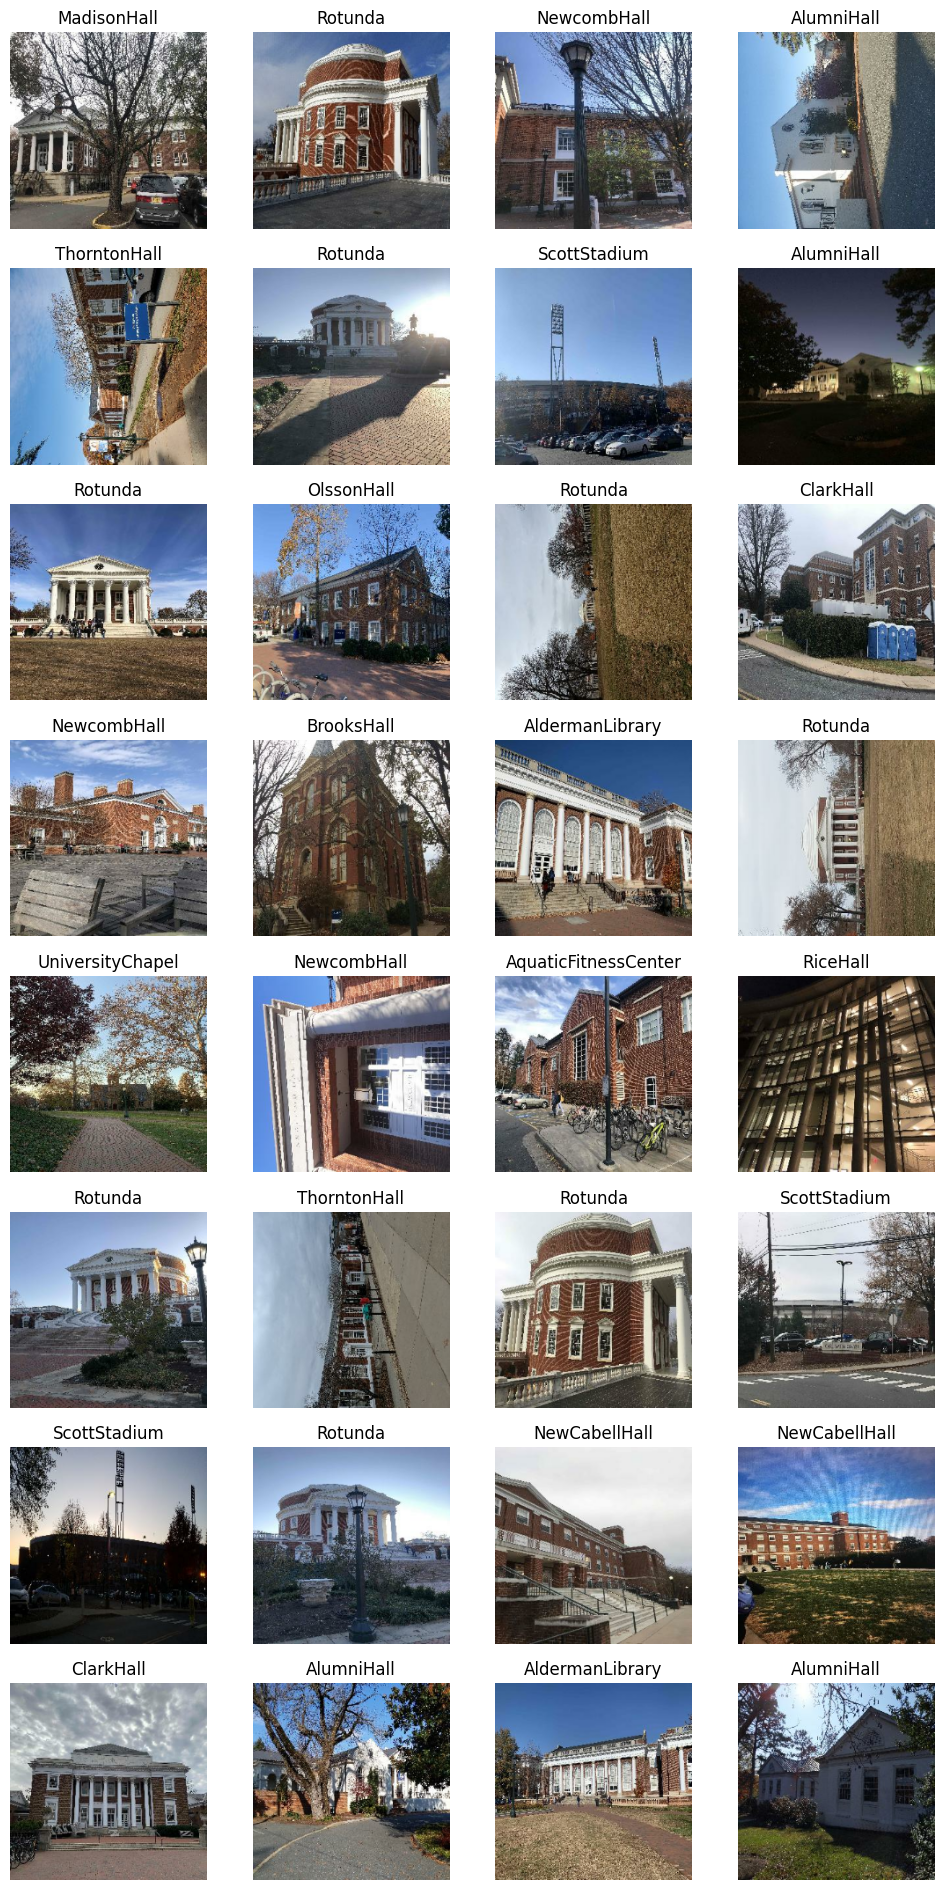

In [6]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter',
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall',
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium',
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


In [7]:
# YOUR CODE STARTS HERE

# Step 2: Create your own CNN architecture
You must design your own architecture. To get started, you may get inspiration from one in CNN notebook  (i.e. use one similar to LeNet-5 or AlexNet). You will have to report the design of the architecture:

1.   How many layers does it have?
2.   Why do you decide on a certain number nodes per layer?
3.   Which activation functions do you choose?
4.   How many parameters does it has in total?

Hint: use `myModel.summary()` to learn on the layers and parameters




In [8]:
# Your code here
myModel  = keras.models.Sequential([
    keras.Input(shape=[224,224,3]),
    keras.layers.Conv2D(32, 5, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(18, activation="softmax")
    ])

# myModel.build(input_shape=[224, 224, 3])
myModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 18)                  │       1,806,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,901,138 (7.25 MB)

 Trainable params: 1,901,138 (7.25 MB)

 Non-trainable params: 0 (0.00 B)

1. This model has 8 layers, including 3 conv2d layers.
2. For each layer, I decided the number of filters based off advice online that suggested using a lower number in the earlier layers, when the image information was still being condensed/processed.
3. I chose to use ReLU for the convolutional layers, but then softmax for the output layer.
4. There are 1,901,138 parameters total.

After designing the model, you will need to train it. In order to train, you will need to pick a number of `epoch` (iteration), which `optimizer` to use (from  `keras.optimizers`), a `loss` function, and some `metrics`.

In [ ]:
myEpochs = 10 ##TODO
myOptimizer = "adam" #TODO
myLoss = "sparse_categorical_crossentropy" #TODO
myMetrics = ["accuracy"]#TODO keep in mind that this can be multiple metrics including at least the accuracy
myModel.compile(loss=myLoss, optimizer = myOptimizer, metrics = myMetrics)
history = myModel.fit(train_ds,
                      validation_data=validation_ds,
                      epochs = myEpochs
                      )

Epoch 1/10
211/358 ━━━━━━━━━━━━━━━━━━━━ 11:44 5s/step - accuracy: 0.1706 - loss: 2.7336

Next, you need to create (1) a plot of training and validation `loss` and (2) a plot of training and validation `accuracy`. These plots might give you some insights about your model performance and possibility of overfitting.

Report the performance of your architecture on the validation set in a `confusion matrix`. Make comments on the performance by answering the following questiosns:
- How well do you think your architecture is doing (overall accuracy)?
- Where did it makes mistake most?
- Which classes can be improved?

In [ ]:
# Your evaluation code here
print(history.history.keys())
print(history.history['val_loss'])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# loss
plt.plot([x for x in range(20)], history.history['val_loss'], label="Validation Loss")
plt.plot([x for x in range(20)], history.history['loss'], label="Training Loss")
plt.title('Validation and Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (sparse categorical crossentropy)')
plt.legend()
plt.show()

In [ ]:
# accuracy
plt.plot([x for x in range(20)], history.history['val_accuracy'], label="Validation Accuracy")
plt.plot([x for x in range(20)], history.history['accuracy'], label="Training Accuracy")
plt.title('Validation and Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# import tensorflow_datasets as tfds
# df = tfds.as_dataframe(validation_ds.take(1)) #???????

In [ ]:
#confusion matrix
labels= []
images = []
for image, label in validation_ds.take(90):
  for l in label:
    labels.append(l.numpy())


y_prediction = myModel.predict(validation_ds)
y_prediction = np.argmax(y_prediction, axis = 1)


In [ ]:
labels[:10]

[3, 15, 12, 17, 0, 10, 1, 17, 17, 13]

In [ ]:
y_prediction[:10]

array([12, 10,  9,  8, 16, 13, 14, 16, 17,  3])

In [ ]:
len(labels)

2857

In [ ]:
len(y_prediction)

2857

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, y_prediction , normalize='pred')
for i in range(len(cm)):
  cm[i] = ["%.2f" % el for el in cm[i]]

In [ ]:
import pandas as pd
df = pd.DataFrame(cm)
df.head(20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.02,0.01,0.05,0.04,0.00,0.06,0.02,0.09,0.02,0.01,0.01,0.02,0.04,0.03,0.02,0.04,0.03,0.03,0.0,0.0
1,0.02,0.07,0.05,0.03,0.05,0.06,0.06,0.09,0.04,0.03,0.06,0.06,0.06,0.06,0.06,0.05,0.04,0.04,0.0,0.0
2,0.06,0.04,0.00,0.03,0.00,0.02,0.02,0.03,0.05,0.03,0.04,0.05,0.02,0.03,0.02,0.02,0.04,0.01,0.0,0.0
3,0.08,0.04,0.02,0.06,0.05,0.06,0.05,0.09,0.03,0.02,0.05,0.04,0.06,0.03,0.04,0.04,0.04,0.03,0.0,0.0
4,0.02,0.00,0.02,0.02,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.02,0.01,0.01,0.00,0.02,0.01,0.02,0.0,0.0
5,0.04,0.01,0.00,0.05,0.05,0.04,0.04,0.03,0.02,0.03,0.03,0.05,0.02,0.02,0.02,0.04,0.03,0.03,0.0,0.0
6,0.04,0.06,0.07,0.04,0.00,0.02,0.04,0.14,0.07,0.09,0.07,0.04,0.06,0.06,0.06,0.06,0.06,0.06,0.0,0.0
7,0.06,0.03,0.00,0.03,0.00,0.02,0.01,0.00,0.01,0.03,0.03,0.01,0.03,0.02,0.03,0.01,0.03,0.03,0.0,0.0
8,0.04,0.03,0.07,0.05,0.05,0.06,0.06,0.03,0.06,0.05,0.05,0.04,0.05,0.04,0.05,0.04,0.05,0.10,0.0,0.0
9,0.04,0.07,0.05,0.06,0.15,0.00,0.04,0.06,0.05,0.05,0.05,0.06,0.02,0.06,0.04,0.04,0.04,0.05,0.0,0.0


The model is pretty accurate on the training data, but does not perform well on the validation set. From the confusion matrix, there are several classes that are mistaken for eachother more, such as 13 and 2.

# Step 3: Use a Pre-trained Network with Transfer Learning
Now that you have a your own custom model and some baseline performance, let's see if you can improve the performance using transfer learning and a pre-trained model. You may use any pre-trained model EXCEPT ones that already provided such as `Xception`, `MobileNet`, `EfficientNetB6`. Keep in mind that each pre-trained model may expect a different input shape, so adjust the size of your training images accordingly.

Make sure you report the design of this architecture by answer the same questions 1-4 in Step 3.

Hint: use `ImageNet` as weights when load the pre-train network, then add a `GlobalAveragePooling2D` and an output layer with `softmax` activation.



In [14]:
# Your code here

base_model = keras.applications.VGG19(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(18)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])

model.summary()
print(len(model.layers))

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 143,667,240 (548.05 MB)

 Trainable params: 143,667,240 (548.05 MB)

 Non-trainable params: 0 (0.00 B)

26


1. It has 26 layers and generally follows the pattern of 2 (in the earlier layers) or 4 convolutional layers followed by a max pooling layer.
2. I did not decide the number of nodes, but through pooling the inputs for each layer get smaller and smaller as the image is processed.
3. There is an option to use softmax activation on the last layer.
4. The total parameters is 143,667,240.

Next, you will attempt to adapt this pre-trained model to your UVA Landmark dataset. It is recommended that you tried the two-phase training approach for your model:

1.   Phase 1: Freeze the pre-train weights and only train the top layer
2.   Phase 2: Train the entire network with much smaller learning rate (adapt the model to UVA data, but avoid destroying the transfered weights).



In [ ]:
# Phase 1 code here

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])


In [ ]:
history = model.fit(train_ds,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=validation_ds,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    )

In [ ]:
# Phase 2 code here
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Repeat the same reporting of performance using the confusion matrix:
- Did this pre-trained network do better overall?
- In which class it improve the accuracy from the above model?
- Which class still has low performance?

Typically, your network must have a reasonable performance of at least 84% overall accuracy to be considered successful in this domain. If your network achieves a accuracy of 94% or above on the validation set, you will also recieve a 10 bonus points, so keep trying!

# Step 4: Reflection

Write at least a paragraph answering these prompts: How did your own network perform in comparison to the pre-trained one? What are the major differences between the architectures? Additionally, report on your experience implementing different models for this assignment (Was it hard/easy/fun?, from which part did you learn the most?)!